# Evaluation of RAG Using Ragas

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

The only way to get started is to get started - so let's grab our dependencies for the day!

> NOTE: Using this notebook as presented will incur a charge of ~$3USD from OpenAI usage.

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Creating a Simple RAG Pipeline with LangChain v.0.2.0
  4. Task 4: Synthetic Dataset Generation for Evaluation using Ragas (Optional)

- 🤝 Breakout Room #2
  1. Task 1: Evaluating our Pipeline with Ragas
  2. Task 2: Testing OpenAI's Claim
  3. Task 3: Selecting an Advanced Retriever and Evaluating

> NOTE: This Notebook *does* contain a bonus challenge, outlined at the bottom of the notebook, which you can complete instead of the notebook for full marks on the assignment.

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room Part #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://python.langchain.com/v0.2/docs/versions/v0_2/) of LangChain v0.2.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [1]:
# !pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai langchain-qdrant

We'll also get the "star of the show" today, which is Ragas!

In [2]:
# !pip install -qU ragas

We'll be leveraging [QDrant](https://qdrant.tech/) again as our LangChain `VectorStore`.

We'll also install `pymupdf` and its dependencies which will allow us to load PDFs using the `PyMuPDFLoader` in the `langchain-community` package!

In [3]:
# !pip install -qU qdrant-client pymupdf pandas

## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [1]:
import os
import openai
import getpass
from langchain_core.tracers.context import tracing_v2_enabled

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIM-WEEK4-DAY2-SDG-AND-EVAL"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Task 3: Creating a Simple RAG Pipeline with LangChain v0.2.0

Building on what we've been learning, we'll be leveraging LangChain v0.2.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

- [`PyMuPDFLoader`](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.2.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [2]:
from langchain_community.document_loaders import PyMuPDFLoader

PDF_LINK = "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf"

loader = PyMuPDFLoader(
    ### YOUR CODE HERE
    file_path = PDF_LINK
)

# documents = ### YOUR CODE HERE
documents = loader.load()
print(len(documents))

195


In [3]:
# 🚀 My own cell

for field in documents[0].__fields__:
    if field == "page_content": continue
    print(f"{field}: {getattr(documents[0], field)}")


print('-'*80)
print(documents[1].page_content[:1000])

id: None
metadata: {'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 0, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': ''}
type: Document
--------------------------------------------------------------------------------
The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen



#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

- [`RecursiveCharacterTextSplitter`](https://api.python.langchain.com/en/latest/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#langchain-text-splitters-character-recursivecharactertextsplitter)

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 200
CHUNK_OVERLAP = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CHUNK_SIZE,
    chunk_overlap = CHUNK_OVERLAP
)

# documents = ### YOUR CODE HERE
documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [5]:
len(documents)

1864

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

- [`OpenAIEmbeddings`](https://api.python.langchain.com/en/latest/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain-openai-embeddings-base-openaiembeddings)

> NOTE: We are purposefully using an older embedding model to try and answer the guiding question: Is TE3 better than Ada-002?

In [6]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL = "text-embedding-ada-002"

embeddings = OpenAIEmbeddings(
    ### YOUR CODE HERE
    model = EMBEDDING_MODEL
)

#### Creating a QDrant VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

- [`Qdrant`](https://api.python.langchain.com/en/latest/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore)

> NOTE: You'll need to provide the embedding dimension for Ada-002!

In [7]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

LOCATION = ":memory:"
COLLECTION_NAME = "PMarca Blogs"
VECTOR_SIZE = 1536

In [8]:
# qdrant_client = ### YOUR CODE HERE
qdrant_client = QdrantClient(location = LOCATION)

qdrant_client.create_collection(
    ### YOUR CODE HERE
    collection_name = COLLECTION_NAME,
    vectors_config = VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE)
)

qdrant_vector_store = QdrantVectorStore(
    ### YOUR CODE HERE
    client = qdrant_client,
    collection_name=COLLECTION_NAME,
    embedding=embeddings
)

ids = qdrant_vector_store.add_documents(documents)

#### ❓ Question #1:

List out a few of the techniques that Qdrant uses that make it performant.

> NOTE: Check the [documentation](https://qdrant.tech/documentation/overview/) for more information about QDrant!

#### 🚀 Answer to Question #1:

In [9]:
# 🚀 Similarity search

query = "How does the tendency to avoid inconsistency contribute to people being reluctant to change?"
results = qdrant_vector_store.similarity_search(query, k=3)
for result in results:
    print(result.page_content[:1000])
    print('-'*80)


Five: Inconsistency-Avoidance Tendency
[People are] reluctant to change, which is a form of inconsistency
avoidance. We see this in all human habits, constructive and
--------------------------------------------------------------------------------
less brain-blocked by its previous conclusions…
One corollary of Inconsistency-Avoidance Tendency is that a per-
son making big sacriXces in the course of assuming a new identity
--------------------------------------------------------------------------------
[T]ending to be maintained in place by the anti-change tendency
of the brain are one’s previous conclusions, human loyalties, repu-
tational identity, commitments…
--------------------------------------------------------------------------------


In [11]:
# 🚀 Hybrid search
from langchain_qdrant import FastEmbedSparse, RetrievalMode

dense_embeddings = OpenAIEmbeddings()
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")


hybrid_qdrant_vector_store = QdrantVectorStore.from_documents(
    documents = documents,
    embedding = dense_embeddings,
    sparse_embedding = sparse_embeddings,
    location = ":memory:",
    collection_name = "PMarca Blogs for Hybrid Search",
    retrieval_mode = RetrievalMode.HYBRID,
)

query = "How does the tendency to avoid inconsistency contribute to people being reluctant to change?"
results = hybrid_qdrant_vector_store.similarity_search(query, k=3)

for result in results:
    print(result.page_content[:1000])
    print('-'*80)

Fetching 29 files:   0%|          | 0/29 [00:00<?, ?it/s]

danish.txt:   0%|          | 0.00/424 [00:00<?, ?B/s]

arabic.txt:   0%|          | 0.00/6.35k [00:00<?, ?B/s]

bengali.txt:   0%|          | 0.00/5.44k [00:00<?, ?B/s]

azerbaijani.txt:   0%|          | 0.00/967 [00:00<?, ?B/s]

catalan.txt:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

dutch.txt:   0%|          | 0.00/453 [00:00<?, ?B/s]

chinese.txt:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

basque.txt:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

english.txt:   0%|          | 0.00/936 [00:00<?, ?B/s]

finnish.txt:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

hebrew.txt:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

hinglish.txt:   0%|          | 0.00/5.96k [00:00<?, ?B/s]

hungarian.txt:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

french.txt:   0%|          | 0.00/813 [00:00<?, ?B/s]

greek.txt:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

german.txt:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

indonesian.txt:   0%|          | 0.00/6.45k [00:00<?, ?B/s]

kazakh.txt:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

italian.txt:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

nepali.txt:   0%|          | 0.00/3.61k [00:00<?, ?B/s]

norwegian.txt:   0%|          | 0.00/851 [00:00<?, ?B/s]

portuguese.txt:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

romanian.txt:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

slovene.txt:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

russian.txt:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

spanish.txt:   0%|          | 0.00/2.18k [00:00<?, ?B/s]

turkish.txt:   0%|          | 0.00/260 [00:00<?, ?B/s]

tajik.txt:   0%|          | 0.00/1.82k [00:00<?, ?B/s]

swedish.txt:   0%|          | 0.00/559 [00:00<?, ?B/s]

Five: Inconsistency-Avoidance Tendency
[People are] reluctant to change, which is a form of inconsistency
avoidance. We see this in all human habits, constructive and
--------------------------------------------------------------------------------
less brain-blocked by its previous conclusions…
One corollary of Inconsistency-Avoidance Tendency is that a per-
son making big sacriXces in the course of assuming a new identity
--------------------------------------------------------------------------------
And avoid, avoid, avoid.
Unethical people are unethical by nature, and the odds of a
metaphorical jailhouse conversion are quite low.
Priests, rabbis, and ministers should give people a second
--------------------------------------------------------------------------------


In [12]:
# 🚀 Search with filtering
from qdrant_client import models

query = "How does the tendency to avoid inconsistency contribute to people being reluctant to change?"
results = qdrant_vector_store.similarity_search(
    query = query, 
    k = 3,
    filter = models.Filter( 
            must=[  models.FieldCondition( key="metadata.page", range=models.Range(gte=190, lte=210) ) ] 
        )
    )

for result in results:
    print(result.page_content[:1000])
    print('-'*80)


comes along. And while you’re at it, stop using most everything
else also, please. Cut it out with the fads already. Posthaste. Chop
chop.
--------------------------------------------------------------------------------
one knows that you shouldn’t need to raise more than $5.37 in
loose change to start a new web business. I mean, c’mon.
Entrepreneurs? Smoking dope. What are they thinking? Why
--------------------------------------------------------------------------------
In it, I attempted to use “logic” to explain the reasons we are
most likely not in another dot com bubble.
Since that time, talk of a new dot com bubble or Web 2.0 bubble
--------------------------------------------------------------------------------


#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [10]:
# retriever = ### YOUR CODE HERE
retriever = qdrant_vector_store.as_retriever().with_config({'run_name':'RETRIEVER'})

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [11]:
retrieved_documents = retriever.invoke("What is a rule of thumb for selecting an industry to invest in?")

In [12]:
for doc in retrieved_documents:
  print(doc)
  print('-'*80)

page_content='the existing order — and make sure that those forces of change
have a reasonable chance at succeeding.
Second rule of thumb:
Once you have picked an industry, get right to the center of it' metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 125, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '55d3819eeff544a08d08456c5dfec7a6', '_collection_name': 'PMarca Blogs'}
--------------------------------------------------------------------------------
page_content='Third rule:
In a rapidly changing Held like technology, the best place to
get experience when you’re starting out is in yo

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

In [13]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")
print(type(retrieval_qa_prompt))

<class 'langchain_core.prompts.chat.ChatPromptTemplate'>


/home/jetlee/anaconda3/envs/AIE4/lib/python3.11/site-packages/langsmith/client.py:5515: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [14]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

In [15]:
from langchain.prompts import ChatPromptTemplate

template = """
### Anwer the following Question based soly on the Context provided. If you are unable to find the answer from Context, just say "I don't know".

Question:
{question}

Context:
{context}
"""

prompt = ChatPromptTemplate([('human', template)])

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [16]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

retrieval_augmented_qa_chain = (
    RunnablePassthrough.assign(
        context = itemgetter("question") | retriever
        ).with_config({'run_name': 'R_FOR_RAG'})
    | RunnablePassthrough.assign(
        response = prompt.with_config({'run_name':'A_FOR_RAG'}) | primary_qa_llm.with_config({'run_name':'G_FOR_RAG'})
        ).with_config({'run_name': 'AG_FOR_RAG'})
    | {"response": itemgetter("response"), "context": itemgetter("context")} 
).with_config({'run_name': 'RAG'})



Let's test it out!

In [17]:
question = "What is a rule of thumb for selecting an industry to invest in?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)

A rule of thumb for selecting an industry to invest in is to ensure that the forces of change within that industry have a reasonable chance of succeeding.


In [18]:
question = "What did Pink Floyd have to say about how to proceed when investing in a new industry?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)
print(result["context"])

I don't know.
[Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 15, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': 'cb296ecf644a4e8781635b6647fc570f', '_collection_name': 'PMarca Blogs'}, page_content='ask if you can call them again if things change.\nTrust me — they’d much rather be saying “yes” than “no” —\nthey need all the good investments they can get.\nSecond, consider the environment.'), Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

## Task 4: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evaluating on every core metric today, but in order to do that - we'll need to create a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

In [19]:
loader = PyMuPDFLoader(
    "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?

In [20]:
len(eval_documents)

624

> NOTE: 🛑 Running this cell as presented will incur a charge of ~$3USD from OpenAI usage. Most of this cost is produced by the Synthetic Data Generation step. **YOU CAN SKIP THIS STEP BY LOADING THE `.csv` DIRECTLY FROM OUR REPOSITORY.** 🛑

#### Optional: SDG for Evaluation

In [21]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

num_qa_pairs = 20 # You can reduce the number of QA pairs to 5 if you're experiencing rate-limiting issues

# testset = generator.generate_with_langchain_docs(eval_documents, num_qa_pairs, distributions)
# testset.to_pandas()

Let's look at the output and see what we can learn about it!

In [22]:
# testset.test_data[0]

In [23]:
# testset_df = testset.to_pandas()
# testset_df.to_csv("testset.csv")


#### PREFERRED: Download `.csv` from DataRepository

In [24]:
# !git clone https://github.com/AI-Maker-Space/DataRepository.git

In [25]:
# !mv DataRepository/testset.csv .

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [26]:
import pandas as pd

test_df = pd.read_csv("testset.csv")

In [27]:
test_df.drop(columns=["Unnamed: 0"], inplace=True)
test_df

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,How does the tendency to avoid inconsistency c...,['Five: Inconsistency-Avoidance Tendency\n[Peo...,The tendency to avoid inconsistency contribute...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
1,What are some of the challenges faced by start...,['structure that any established company has.\...,"In a startup, it is easy for the code not to g...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
2,What factors should be considered when decidin...,['Part 2: Skills and education\n[Please read m...,The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
3,What should be valued when evaluating candidat...,"[""How to hire the best people you've\never wor...",The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
4,What are the consequences of not raising enoug...,['Here’s why you shouldn’t do that:\nWhat are ...,Not raising enough money risks the survival of...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
5,How does Structured Procrastination suggest us...,['like?\nStructured procrastination\nThis is a...,Structured Procrastination suggests that inste...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
6,What analogy is used to describe the layers of...,['as if it’s an onion. Just like you peel an o...,The analogy used to describe the layers of ris...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
7,How can Structured Procrastination be used to ...,['like?\nStructured procrastination\nThis is a...,Structured Procrastination suggests that inste...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
8,How is the quality of a startup's product defi...,['Let’s start by deXning terms.\nThe caliber o...,The quality of a startup's product in the tech...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
9,What role can a campus computer lab play in he...,"['undergrads to do some of the work, and being...",A campus computer lab can play a role in helpi...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True


In [28]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

print(test_questions[0])
print(test_groundtruths[0])

How does the tendency to avoid inconsistency contribute to people being reluctant to change?
The tendency to avoid inconsistency contributes to people being reluctant to change because individuals are often hesitant to alter their habits, whether constructive or destructive. Many people struggle to eliminate bad habits, even when they are aware of their negative impact. This resistance to change is deeply ingrained, with some early-formed habits being perceived as destiny. Therefore, the fear of inconsistency and the comfort of familiar habits can hinder individuals from embracing change.


Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [93]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [97]:
from datasets import Dataset

#🚀 HuggingFace dataset
response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

response_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 19
})

Let's take a peek and see what that looks like!

In [98]:
response_dataset[0]

{'question': 'How does the tendency to avoid inconsistency contribute to people being reluctant to change?',
 'answer': 'The tendency to avoid inconsistency contributes to people being reluctant to change because change itself is viewed as a form of inconsistency. This avoidance is reflected in human habits and is maintained by previous conclusions, loyalties, reputational identity, and commitments, which create an anti-change tendency in the brain. As a result, individuals may resist new ideas or identities until they are ready to embrace change, often requiring time or a new generation to facilitate this shift.',
 'contexts': ['Five: Inconsistency-Avoidance Tendency\n[People are] reluctant to change, which is a form of inconsistency\navoidance. We see this in all human habits, constructive and',
  'less brain-blocked by its previous conclusions…\nOne corollary of Inconsistency-Avoidance Tendency is that a per-\nson making big sacriXces in the course of assuming a new identity',
  '[T

# 🤝 Breakout Room Part #2

## Task 1: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [29]:
from ragas import evaluate

from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [104]:
with tracing_v2_enabled('AIM-WEEK4-DAY2-RAGAS-EVAL'):
    results = evaluate(
        dataset = response_dataset, 
        metrics = metrics
        # 🚀 If 'llm' is not set, then Ragas takes the default llm -> 'gpt-4o-mini'
        )

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

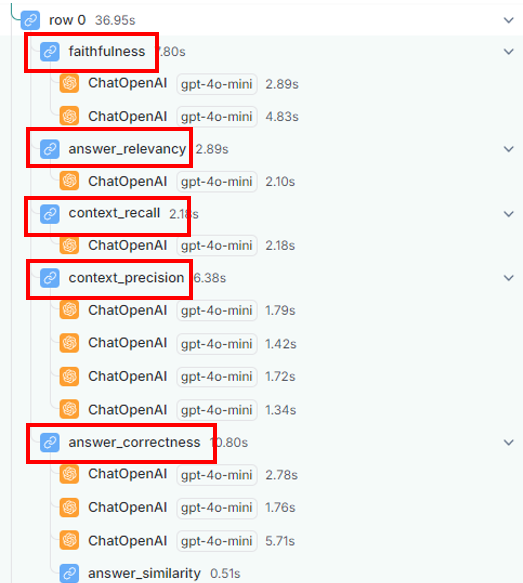

In [105]:
results

{'faithfulness': 0.6544, 'answer_relevancy': 0.7225, 'context_recall': 0.6096, 'context_precision': 0.6550, 'answer_correctness': 0.5590}

In [106]:
results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,How does the tendency to avoid inconsistency c...,The tendency to avoid inconsistency contribute...,[Five: Inconsistency-Avoidance Tendency\n[Peop...,The tendency to avoid inconsistency contribute...,0.909091,0.936709,0.500000,0.805556,0.462359
1,What are some of the challenges faced by start...,Some of the challenges faced by startups in es...,[ied and determined. Sales calls get made. The...,"In a startup, it is easy for the code not to g...",1.000000,0.991209,0.666667,1.000000,0.460683
2,What factors should be considered when decidin...,I don't know.,[including your formal education. So I will st...,The answer to given question is not present in...,0.000000,0.000000,1.000000,0.000000,0.195200
3,What should be valued when evaluating candidat...,"When evaluating candidates for a startup, it i...",[priate for your particular startup.\nWith a w...,The answer to given question is not present in...,0.500000,1.000000,1.000000,0.000000,0.179588
4,What are the consequences of not raising enoug...,Not raising enough money risks the survival of...,[Here’s why you shouldn’t do that:\nWhat are t...,Not raising enough money risks the survival of...,0.666667,0.966323,0.333333,0.833333,0.518752
5,How does Structured Procrastination suggest us...,Structured Procrastination suggests that inste...,[standing.)\nThe gist of Structured Procrastin...,Structured Procrastination suggests that inste...,1.000000,0.957872,1.000000,0.916667,0.996909
6,What analogy is used to describe the layers of...,The analogy used to describe the layers of ris...,[as if it’s an onion. Just like you peel an on...,The analogy used to describe the layers of ris...,1.000000,1.000000,1.000000,0.750000,0.891537
7,How can Structured Procrastination be used to ...,Structured Procrastination can be used to one'...,[standing.)\nThe gist of Structured Procrastin...,Structured Procrastination suggests that inste...,1.000000,0.987980,0.500000,0.805556,0.992850
8,How is the quality of a startup's product defi...,The quality of a startup's product in the cont...,[The quality of a startup’s pr\nproduct\noduct...,The quality of a startup's product in the tech...,1.000000,0.993584,0.000000,1.000000,0.651053
9,What role can a campus computer lab play in he...,A campus computer lab can provide undergraduat...,[What should I do while I’m in school?\nI’m a ...,A campus computer lab can play a role in helpi...,1.000000,0.972730,0.666667,0.750000,0.871039


## Task : Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #1:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

In [31]:
te3_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

#🚀 We're going to use "text-embedding-3-small" embedding model which is a newer model than "text-embedding-ada-002".
#🚀 OpenAI clains that "text-embedding-3-small" has the same dimension as "text-embedding-ada-002" but more performant.

In [32]:
qdrant_client.create_collection(
    collection_name=COLLECTION_NAME+"TE3",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME+"TE3",
    embedding=te3_embeddings,
)

ids = qdrant_vector_store.add_documents(documents)

#🚀 Create a new collection in Qdrant. The only difference here is that the new collection is populated with te3_embeddings.

In [33]:
te3_retriever = qdrant_vector_store.as_retriever().with_config({'run_name':'RETRIEVER'})

#🚀 Get a LangChain retriever from qdrant_vector_store

te3_retriever.invoke("How does the tendency to avoid inconsistency contribute to people being reluctant to change?")


[Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 155, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '0c24c543f54a4804907ce85dea8125c5', '_collection_name': 'PMarca BlogsTE3'}, page_content='Five: Inconsistency-Avoidance Tendency\n[People are] reluctant to change, which is a form of inconsistency\navoidance. We see this in all human habits, constructive and'),
 Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page'

In [37]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)
document_chain

#🚀 This out-of-the-box chain is to pass a list of Documents to a model.
#🚀 It corresponds to "Runnable part 2 + Runnable part 3" in the code below

# retrieval_augmented_qa_chain = (
#     {"context": itemgetter("question") | retriever, "question": itemgetter("question")}  # Runnable part 1
#     | RunnablePassthrough.assign(context=itemgetter("context"))   # Runnable part 2
#     | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}   # Runnable part 3
# )


RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), config={'run_name': 'format_inputs'})
| ChatPromptTemplate(input_variables=['context', 'input'], optional_variables=['chat_history'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'chat_history': []}, metadata={'lc_hub_owner': 'langchain-ai', 'lc_hub_repo': 'retrieval-qa-chat', 'lc_hub_commit_hash': 'b60afb6297176b022244feb83066e10ecadcda7b90423654c4a9d45e7a73cebc'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template='Answer any use questions based solely on the context below:\n\n<context>\n{context}\n</context>')), MessagesPlaceholder(variable

In [38]:
from langchain.chains import create_retrieval_chain

te3_retrieval_chain = create_retrieval_chain( (lambda x: x["input"]) | te3_retriever, document_chain) 
#🚀 We need to pass lambda x: x["input"] |te3_retriever instead of te3_retriever because of LangChain version 


#🚀 create_retrieval_chain() returns a RAG chain out of the box.
#🚀 It is equivalent to the code below (Sligtly diffent in terms of the output format.)

# retrieval_augmented_qa_chain = (
#     {"context": itemgetter("question") | retriever, "question": itemgetter("question")}  # Runnable part 1
#     | RunnablePassthrough.assign(context=itemgetter("context"))   # Runnable part 2
#     | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}   # Runnable part 3
# )

In [140]:
answers = []
contexts = []

for question in test_questions:
  response = te3_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

In [142]:
te3_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

te3_response_dataset_advanced_retrieval

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 19
})

In [143]:
with tracing_v2_enabled('AIM-WEEK4-DAY2-RAGAS-EVAL'):
    te3_advanced_retrieval_results = evaluate(te3_response_dataset_advanced_retrieval, metrics)

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

In [144]:
te3_advanced_retrieval_results

{'faithfulness': 0.8000, 'answer_relevancy': 0.9717, 'context_recall': 0.6228, 'context_precision': 0.6287, 'answer_correctness': 0.6506}

In [145]:
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(te3_advanced_retrieval_results.items()), columns=['Metric', 'TE3'])

df_merged = pd.merge(df_baseline, df_comparison, on='Metric')

df_merged['Baseline -> TE3'] = df_merged['TE3'] - df_merged['ADA']

df_merged

,Metric,ADA,TE3,Baseline -> TE3
0,faithfulness,0.654363,0.800021,0.145658
1,answer_relevancy,0.722494,0.971692,0.249198
2,context_recall,0.609649,0.622807,0.013158
3,context_precision,0.654971,0.628655,-0.026316
4,answer_correctness,0.559025,0.650568,0.091543


#### ❓ Question #3:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

#### 🚀 Answer to Question #3
- The "text-embedding-3-small" model shows improvements across all four criteria, except for 'context precision'.
- A decrease in 'context precision' indicates that the retriever may fetch slightly less relevant documents.
- However, the primary value of the RAG system for end users lies in the quality of the 'answer,' not the 'context.' In this regard, the te3_retrieval_chain is clearly superior to the one using 'text-embedding-ada-002'.


## Task 5: Selecting an Advanced Retriever and Evaluating

#### 🏗️ Activity #2

While the changes that occured due to modifying the embedding model were desirable - you're now tasked with improving `context_recall`, or `context_precision` (or both!).

You'll follow these steps:

1. Reason about this list of Advanced Retrieval methods:
  - [Contextual Compression (Reranker)](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/contextual_compression/)
    - 🚀 Contextual compression improves retrieval by condensing documents based on query relevance to reduce irrelevant information and optimize responses.
  - [MultiQueryRetriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/MultiQueryRetriever/)
    - 🚀 The MultiQueryRetriever enhances distance-based vector retrieval by automatically generating multiple queries from different perspectives, retrieving relevant documents for each, and combining them to provide a more comprehensive set of results.
  - [Parent Document Retriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/parent_document_retriever/)
    - 🚀 The ParentDocumentRetriever balances the need for small, accurate document embeddings and sufficient context by retrieving small chunks and then returning the larger parent documents they originated from.
2. Select the method you think will be the most performant.
  - 🚀 I will try Contextual Compression as my first advanced RAG.
3. Implement that method.
4. Create a LCEL chain that utlizes the new Retriever method.
5. Evaluate this LCEL and compare to the TE3 results.

> NOTE: We will spend more time in Session 14 diving into advanced retrieval methods, this activity is only to serve as a basic introduction to the idea of component-wise improvements and how they might impact metrics.

In [189]:
### YOUR CODE HERE (https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/contextual_compression/)

# 🚀 Step 1) Compose a compressor using LCEL
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.documents import Document

def make_it_into_batch(input: dict):
    return [{'question':input['question'], 'context':c} for c in input['context']]
enter_runnable = RunnableLambda(make_it_into_batch)

template= (
    "Given the following question and context, extract any part of the context *AS IS* that is relevant to answer the question."
    " If none of the context is relevant return NO_OUTPUT. "
    "\n\nRemember, *DO NOT* edit the extracted parts of the context.\n\n> Question: {question}\n> Context:\n>>>\n{context}\n>>>\nExtracted relevant parts:"
)
compression_prompt = ChatPromptTemplate([('human', template)])

compression_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

def compressor_parser(responses):
    return [Document(page_content=response.content) for response in responses if response.content != "NO_OUTPUT"]
parser_runnable = RunnableLambda(compressor_parser)

compressor = (enter_runnable | (compression_prompt | compression_llm).map() | parser_runnable).with_config({'run_name':'CONTEXT_COMPRESSOR'})


# 🚀 Step 2) Upgrade our 'te3_retriever' to 'contextual-compression retriever' using LCEL
contextual_compression_retriever = (RunnablePassthrough.assign(context=itemgetter('question') | te3_retriever)  | compressor).with_config({'run_name':'CONTEXT_COMPRESSION_RETRIEVER'}) 


# # 🚀 Step 3) Implement a RAG

template = """
### Anwer the following Question based soly on the Context provided. If you are unable to find the answer from Context, just say "I don't know".

Question:
{question}

Context:
{context}
"""
rag_prompt = ChatPromptTemplate([('human', template)])
rag_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

RAG_with_contextual_compression = (
    RunnablePassthrough.assign(context = contextual_compression_retriever).with_config({'run_name':'R_FOR_RAG'})
    | RunnablePassthrough.assign(response = rag_prompt.with_config({'run_name':'A_FOR_RAG'}) | rag_llm.with_config({'run_name':'G_FOR_RAG'})).with_config({'run_name': 'AG_FOR_RAG'})
    | {"answer": itemgetter("response"), "context": itemgetter("context")} 
).with_config({'run_name': 'RAG'})

In [196]:
# 🚀 Step 4) Evaluate it!

answers = []
contexts = []

for question in test_questions:
  response = RAG_with_contextual_compression.invoke({"question" : question})
  answers.append(response["answer"].content)
  contexts.append([context.page_content for context in response["context"]])

from datasets import Dataset
RAG_with_contextual_compression_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})


evaluation_llm = ChatOpenAI(model_name="gpt-4o-mini-2024-07-18", temperature=0)
with tracing_v2_enabled('AIM-WEEK4-DAY2-RAGAS-EVAL'):
    RAG_with_contextual_compression_result = evaluate(RAG_with_contextual_compression_dataset, metrics, llm=evaluation_llm)

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

In [199]:
RAG_with_contextual_compression_result 

{'faithfulness': 0.5453, 'answer_relevancy': 0.6174, 'context_recall': 0.4035, 'context_precision': 0.6330, 'answer_correctness': 0.4634}

In [200]:
# 🚀 Step 5) Visualize it with pandas

df = pd.DataFrame(columns=['Metric', 'ADA', 'TE3', 'Compression'])

Metric = ['faithfullness', 'answer_relevancy', 'context_recall', 'context_precision', 'answer_correctness']
ADA = [0.654363, 0.722494, 0.609649, 0.654971, 0.559025]
TE3 = [0.800021, 0.971692, 0.622807, 0.628655, 0.650568]
Compression = [0.5453, 0.6174,  0.4035, 0.6330, 0.4634]
df['Metric'] = Metric
df['ADA'] = ADA
df['TE3'] = TE3
df['Compression'] = Compression
df['TE3->Compression'] = df['Compression'] - df['TE3'] 

df

,Metric,ADA,TE3,Compression,TE3->Compression
0,faithfullness,0.654363,0.800021,0.5453,-0.254721
1,answer_relevancy,0.722494,0.971692,0.6174,-0.354292
2,context_recall,0.609649,0.622807,0.4035,-0.219307
3,context_precision,0.654971,0.628655,0.6330,0.004345
4,answer_correctness,0.559025,0.650568,0.4634,-0.187168


##### 🚀 Step 5) Review the result
- Only context_precision get advantages of contextual compression. Maybe it was because the compressor discards seemingly unrelavant documents...
- Aggresively compressing documents resulted in some loss of information passed into the llm. That's possible reason for the poor performance.

#### 🚧 BONUS CHALLENGE 🚧

> NOTE: Completing this challenge will provide full marks on the assignment, regardless of the complete of the notebook. You do not need to complete this in the notebook for full marks.

##### **MINIMUM REQUIREMENTS**:

1. Baseline `LCEL RAG` Application using `NAIVE RETRIEVAL`
2. Baseline Evaluation using `RAGAS METRICS`
  - [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
  - [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
  - [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
  - [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
  - [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)
3. Implement a `SEMANTIC CHUNKING STRATEGY`.
4. Create an `LCEL RAG` Application using `SEMANTIC CHUNKING` with `NAIVE RETRIEVAL`.
5. Compare and contrast results.

##### **SEMANTIC CHUNKING REQUIREMENTS**:

Chunk semantically similar (based on designed threshold) sentences, and then paragraphs, greedily, up to a maximum chunk size. Minimum chunk size is a single sentence.

Have fun!

In [221]:
# 🚀 Step 1) Define helper functions

from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import Qdrant
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, answer_correctness, context_recall, context_precision
from datasets import Dataset
from tqdm.notebook import tqdm
import pickle
from typing import Literal
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings



def get_chunked_documents(strategy: Literal['recursive', 'semantic'], document_path="https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf"):
    documents  = PyMuPDFLoader(file_path = document_path).load()
    if strategy == 'recursive':
        text_splitter = RecursiveCharacterTextSplitter(chunk_size = 200, chunk_overlap = 50)
        documents = text_splitter.split_documents(documents)
    elif strategy == 'semantic':
        embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
        semantic_chunker = SemanticChunker(embeddings = embeddings)
        documents = semantic_chunker.split_documents(documents)
    return documents



def get_base_retriever(chunking_strategy: Literal['recursive', 'semantic'], embeddings = OpenAIEmbeddings(model="text-embedding-3-small"), document_path="https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf"):
    documents = get_chunked_documents(strategy=chunking_strategy)

    vectorstore = Qdrant.from_documents(
        documents=documents,
        embedding=embeddings,
        location=":memory:"
    )
    return vectorstore.as_retriever()


def get_lcel_rag(retriever, rag_name: str):
    template = """
    ### Anwer the following Question based soly on the Context provided. If you are unable to find the answer from Context, just say "I don't know".

    Question:
    {question}

    Context:
    {context}
    """
    prompt = ChatPromptTemplate([('human', template)])

    rag_chain = (
        RunnablePassthrough.assign(
            context = itemgetter("question") | retriever
            ).with_config({'run_name': 'R_FOR_RAG'})
        | RunnablePassthrough.assign(
            answer = prompt.with_config({'run_name':'A_FOR_RAG'}) | primary_qa_llm.with_config({'run_name':'G_FOR_RAG'})
            ).with_config({'run_name': 'AG_FOR_RAG'})
        | {"answer": itemgetter("answer"), "context": itemgetter("context")} 
    ).with_config({'run_name': rag_name})
    return rag_chain 


def evaluate_rag_with_ragas(rag_chain, test_questions: list[str], test_groundtruths: list[str]):

    answers = []
    contexts = []
    with tracing_v2_enabled('GET-PREDICTIONS'):
        for question in tqdm(test_questions):
            response = rag_chain.invoke({"question" : question})
            answers.append(response["answer"].content)
            contexts.append([context.page_content for context in response["context"]])


    dataset = Dataset.from_dict({
        "question" : test_questions,
        "answer" : answers,
        "contexts" : contexts,
        "ground_truth" : test_groundtruths
    })

    metrics = [faithfulness, answer_relevancy, context_recall, context_precision, answer_correctness]
    evaluation_llm = ChatOpenAI(model_name="gpt-4o-mini-2024-07-18", temperature=0)
    with tracing_v2_enabled('RAGAS-EVAL'):
        results = evaluate(dataset=dataset, metrics=metrics, llm=evaluation_llm)
    return results
   

In [201]:
# 🚀 Step 2) Get a naive LCEL RAG and evaluate it.
base_retriever = get_base_retriever(chunking_strategy='recursive')
base_rag_chain = get_lcel_rag(base_retriever, 'BASE_RETRIEVER_RAG')

with open('test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)
with open('test_groundtruths.pkl', 'rb') as f:
    test_groundtruths = pickle.load(f)
    
base_rag_chain_results = evaluate_rag_with_ragas(base_rag_chain, test_questions, test_groundtruths)
with open('base_rag_chain_results.pkl', 'wb') as f:
    pickle.dump(base_rag_chain_results, f)

print(base_rag_chain_results)

{'faithfulness': 0.6773, 'answer_relevancy': 0.8203, 'context_recall': 0.6228, 'context_precision': 0.6287, 'answer_correctness': 0.5658}


In [228]:
# 🚀 Step 3) SEMANTIC CHUNKING!!
semantic_chunking_retriever = get_base_retriever(chunking_strategy='semantic')
semantic_chunking_retriever_rag_chain = get_lcel_rag(semantic_chunking_retriever, 'SEMANTIC_CHUNKING_RETRIEVER_RAG')

with open('test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)
with open('test_groundtruths.pkl', 'rb') as f:
    test_groundtruths = pickle.load(f)
    
semantic_chunking_retriever_rag_results = evaluate_rag_with_ragas(semantic_chunking_retriever_rag_chain, test_questions, test_groundtruths)
with open('semantic_chunking_retriever_rag_results.pkl', 'wb') as f:
    pickle.dump(semantic_chunking_retriever_rag_results, f)

print(semantic_chunking_retriever_rag_results)

  0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/95 [00:00<?, ?it/s]

{'faithfulness': 0.7967, 'answer_relevancy': 0.8650, 'context_recall': 0.9561, 'context_precision': 0.7193, 'answer_correctness': 0.5630}


In [234]:
# 🚀 Step 4) Compare the result!

df = pd.DataFrame(columns=['Metric', 'ADA', 'TE3', 'Compression', 'Semantic'])

Metric = ['faithfullness', 'answer_relevancy', 'context_recall', 'context_precision', 'answer_correctness']
ADA = [0.654363, 0.722494, 0.609649, 0.654971, 0.559025]
TE3 = [0.800021, 0.971692, 0.622807, 0.628655, 0.650568]
Compression = [0.5453, 0.6174,  0.4035, 0.6330, 0.4634]
Semantic = [0.7967, 0.8650,  0.9561, 0.7193, 0.5630]
df['Metric'] = Metric
df['ADA'] = ADA
df['TE3'] = TE3
df['Compression'] = Compression
df['Semantic'] = Semantic
df['TE3->Compression'] = df['Compression'] - df['TE3'] 
df['TE3->Semantic'] = df['Semantic'] - df['TE3'] 
df

,Metric,ADA,TE3,Compression,Semantic,TE3->Compression,TE3->Semantic
0,faithfullness,0.654363,0.800021,0.5453,0.7967,-0.254721,-0.003321
1,answer_relevancy,0.722494,0.971692,0.6174,0.8650,-0.354292,-0.106692
2,context_recall,0.609649,0.622807,0.4035,0.9561,-0.219307,0.333293
3,context_precision,0.654971,0.628655,0.6330,0.7193,0.004345,0.090645
4,answer_correctness,0.559025,0.650568,0.4634,0.5630,-0.187168,-0.087568
